In [2]:
import numpy as np 
import scipy.optimize as optimize
import math 
import matplotlib.pyplot as plt     
from dotmap import DotMap
from legendre import legendre_polynomial,legendre_polynomial_dot, lagrange_polynomial, get_collocation
from utils import find_zeros,unique_with_tolerance #, unpack_coefficients

In [3]:
# Check correctness of legendre definitions
ps_N = 9
L_N = legendre_polynomial(ps_N=ps_N)
L_N_dot = legendre_polynomial_dot(ps_N=ps_N)


t_guess_array = np.linspace(start = -1,stop = 1, num= 5*ps_N, endpoint=False)
roots = unique_with_tolerance(find_zeros(L_N_dot,t_guess_array))

assert len(roots) == ps_N-1, f"Inconsistent size of collocation points {len(roots)} != {ps_N-1}"

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.linspace(-1,1,num=1000), L_N(np.linspace(-1,1,num=1000)), label = "$L_N(t)$")
ax.scatter(roots, L_N(roots), label= "Computed collocation points", c = 'green')
ax.grid(visible=True)
ax.legend()


TypeError: legendre_polynomial() got an unexpected keyword argument 'ps_N'

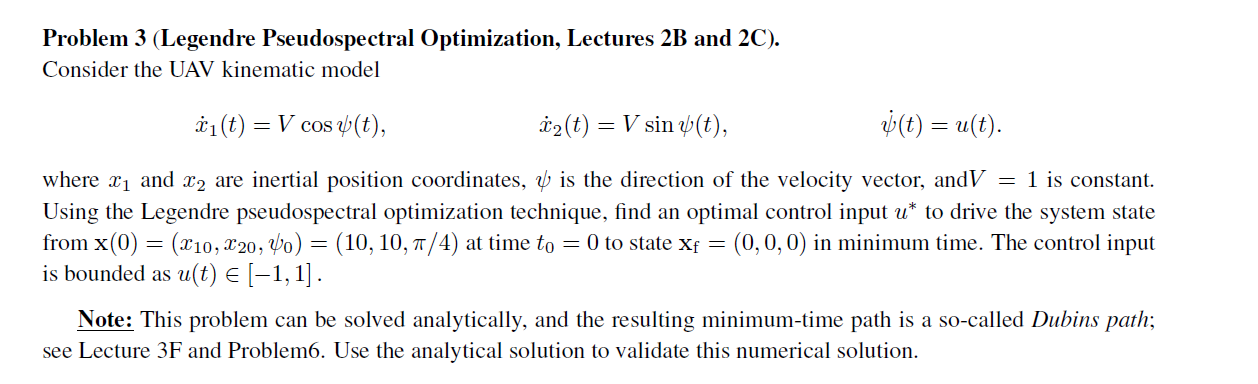

In [ ]:
n_t_pts		= 10001;
# Choose order of Legendre polynomial
ps_N =11;	
LGL_colloc = get_collocation(ps_N=ps_N)
n_state	= 2 # Number of states
n_input	= 1 #Number of inputs
n_colloc	= ps_N + 1 # Number of collocation points
is_tf_free = 0
# Add 1 to number of decision variables if the final time tf is also to be optimized
n_decision_var	= (n_state + n_input)*(ps_N + 1) + is_tf_free #Total number of decision variables
print(n_decision_var)

V = 1 # m/s
# Boundary conditions 
x_init	= np.array([5,2]);
x_term	=np.array([-5,-2])
tau_f = 5
u_lower,u_upper = -1,1 # Inequality control constraints


NameError: name 'get_collocation' is not defined

In [ ]:

def unpack_coefficients(
    q: np.ndarray, n_state: int, n_input: int, n_colloc: int
) -> tuple:
    a_ = np.zeros(
        (n_state, n_colloc)
    )  # These are the state coefficients a_k, i.e., the k_th column is a the k_th column is a_k
    b_ = np.zeros((n_input, n_colloc))
    end_indx = n_state * n_colloc
    for k in range(n_colloc):
        a_[:, k] = q[k:k+ n_colloc*(n_state):n_colloc]
    for k in range(n_colloc):
        b_[:, k] = q[
            (end_indx + n_input * k) : (end_indx + n_input * (k + 1)) # I think this is wrong but works for 1D input
        ]  # %Similarly, these are the input coefficients b_k
    return a_, b_


In [ ]:





# Pack the initial guess into the decision variable q
q_initial_guess= np.concatenate((np.ones(n_colloc*n_state), np.ones(n_colloc*n_input)))

print(q_initial_guess)
print(len(q_initial_guess))
print(n_colloc*(n_state+n_input))
if is_tf_free: 
    # Allocate decision variable \tau_f and provide initial guess
    q_initial_guess = np.concatenate([q_initial_guess,[15]])

assert len(q_initial_guess) == n_decision_var
a,b = unpack_coefficients(q_initial_guess, n_state,n_input, n_colloc)

print(a[:,0])
# print(b)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
36
36
[1. 1.]


In [ ]:

def system_dynamics_f(x_, u_):
	# Kinematics of Dubins problem 
	x_dot= [x_[1], -x_[1] + u_] 
	return np.array(x_dot)
print(system_dynamics_f(x_init,0))

def incremental_cost(x_,u_):
	return  0.5*u_**2 + 0.5*(2*x_[0]**2 + 5*x_[1]**2)

def calculate_cost(q: np.ndarray, n_state:int, n_input: int, n_colloc:int, tau_f = False) -> float:
    # Unpack parameters for readibility
	[a_, b_]= unpack_coefficients(q, n_state,n_input,n_colloc) 
	if not tau_f:
		# TODO: Should do some error catching here. 
		tau_f = q[-1]
	cost_J	= 0
	for k in range(n_colloc):
		w_k		= 2 / (ps_N*(ps_N + 1) * ( LGL_colloc.L_N_tm[k] )**2) # TODO: don't have this function call a global variable. prob just put everything in LGL
		cost_J +=  0.5*tau_f*w_k*incremental_cost(a_[:, k], b_[:, k]) 

	return cost_J


[ 2 -2]


The decision variable in the transcribed optimization problems is q = set of coefficients In normalized time, the i^th state $ x_i$  is
$x_i = \sum_{k=0}^{N} a_ki \phi_k$ and the i_th input is $u_i = \sum_{k=0}^{N} b_ki \phi_k$
We adopt the convention $q = (a_0, a_1, a_2, .. a_N, b_0, b_1, ... b_N)$  i.e., the vectors $a_k$ and $b_k$ stacked.


### Initial guess generation
There is no method of initial guess generation that works for all
systems. It is beneficial to find an initial guess that is feasible,
i.e., satisfies all constraints, or at least as many constraints as
possible. Here we set the states x_1 and x_2 to polynomial functions of
time and deduce the corresponding input u. This may not always be
possible to do, but it can be done for this particular system.


In [ ]:

# CONSTRAINTS OF THE TRANSCRIBED PROBLEM
def calculate_constraints(q: np.ndarray, n_state:int, n_input: int, n_colloc:int, tau_f = False) -> tuple:
	a_, b_= unpack_coefficients(q, n_state,n_input,n_colloc)
	if not tau_f:
		# TODO: Should do some error catching here. 
		tau_f = q[-1]
	
	c_inequality= []
	c_equality	= []

	f_= np.zeros(( n_state, n_colloc) ) 
	for k in np.arange(n_colloc):
		# TODO: This can definitely be vectorized 
		f_[:, k] = system_dynamics_f(a_[:, k], b_[:, k] )
		
		c_inequality = np.concatenate((c_inequality, b_[:,k]- u_lower, b_[:,k]+u_upper))

	for n in range(n_state):
		c_equality_temp =  np.dot(LGL_colloc.D, a_[n,:] - 0.5*tau_f*f_[n, :])

		c_equality = np.concatenate([c_equality,c_equality_temp[1:-1]]) # Don't enforce system dynamics on prescribed boundaries
# 		%-----	Equality constraints arising from boundary conditions

	c_equality	= np.concatenate([ a_[:, 0] - x_init,c_equality, a_[:,-1] - x_term])
# 		c_equality	= [c_equality; a_(:, 1) - x_init];
		# Inequaloty constraints from upper and lower bounds
	
	return c_equality,c_inequality
equality_constraints = lambda q:  calculate_constraints(q,n_state,n_input,n_colloc, tau_f=tau_f)[0]
inequality_constraints = lambda q:  calculate_constraints(q,n_state,n_input,n_colloc, tau_f=tau_f)[1]

a_, b_= unpack_coefficients(q_initial_guess, n_state,n_input,n_colloc)
# print()
print(equality_constraints(q_initial_guess))
# print(np.shape(q_initial_guess))
print(inequality_constraints(q_initial_guess))

[-4.         -1.          1.50000077  1.49999941  1.50000051  1.49999953
  1.50000045  1.49999955  1.50000047  1.49999949  1.50000059  1.49999923
 -1.00000052 -0.99999961 -1.00000034 -0.99999969 -1.0000003  -0.9999997
 -1.00000031 -0.99999966 -1.00000039 -0.99999948  6.          3.        ]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


C:\Users\tagren\AppData\Local\Temp\1\ipykernel_38236\2570246395.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_dot)


In [ ]:
# Optimize
objective = lambda q: calculate_cost(q,n_state,n_input,n_colloc,tau_f=tau_f)
print(objective(q_initial_guess))
result = optimize.minimize(objective, q_initial_guess, method = 'SLSQP', tol = 1e-11, constraints=[{"type": "eq", "fun": equality_constraints},{ "type": "ineq", "fun": inequality_constraints}])
print(result)
a_optimal, b_optimal = unpack_coefficients(result.x,  n_state,n_input,n_colloc)
x_ps_opt	= np.dot(LGL_colloc.phi_l ,a_optimal.transpose());
u_ps_opt	= np.dot(LGL_colloc.phi_l, b_optimal.transpose());
print(equality_constraints(result.x))

[20.00097394]


C:\Users\tagren\AppData\Local\Temp\1\ipykernel_38236\2570246395.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(x_dot)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2.7054743231428606
       x: [ 5.000e+00  3.723e-02 ...  1.861e-01 -5.088e-01]
     nit: 20
     jac: [ 3.788e-01  1.707e-02 ...  4.267e-02 -1.927e-02]
    nfev: 741
    njev: 20
[ 0.00000000e+00  0.00000000e+00 -1.87612256e-18  1.01848030e-17
 -5.79037618e-18  5.32508794e-18 -5.12380924e-18  1.65436228e-18
 -1.85564099e-18  9.25982215e-18 -6.71536052e-18  8.81502195e-18
  1.35447209e-14  4.71844785e-14 -4.55191440e-15  1.11022302e-14
 -9.42579348e-14 -2.63122857e-14 -1.33226763e-14  3.55271368e-15
 -1.03250741e-14 -5.77315973e-15  0.00000000e+00  0.00000000e+00]


(7222, 2)


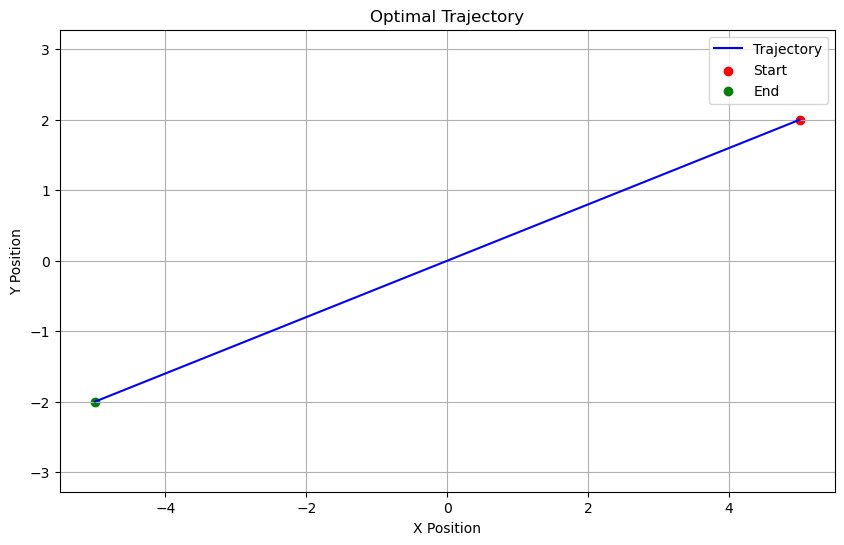

In [ ]:
# Plot the trajectory
print(x_ps_opt.shape)
def plot_trajectory(a_):
    x = a_[:, 0]
    y = a_[:, 1]
    theta = a_[2, :]  # Assuming the third state is heading (theta)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', label='Trajectory')
    plt.scatter(x[0], y[0], color='red', label='Start')
    plt.scatter(x[-1], y[-1], color='green', label='End')

    
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Optimal Trajectory')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
plot_trajectory(x_ps_opt)